In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

from models import *
import utils
from utils import Language
from gen_utils import *
import numpy as np

In [2]:
# cuda vars

long_type = torch.LongTensor
float_type = torch.FloatTensor
use_cuda = torch.cuda.is_available()

if use_cuda:
    long_type = torch.cuda.LongTensor
    float_type = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
TASK = "binary-flip"
COEFF = 1.0

In [4]:
src_lang = Language('src')
trg_lang = Language('trg')

In [5]:
# load vocab of languages
src_lang.load_vocab("data/" + TASK + '_coeff=' + str(COEFF) + ".src.vocab")
trg_lang.load_vocab("data/" + TASK + '_coeff=' + str(COEFF) + ".trg.vocab")

In [6]:
# --------------------------------------------------------#
# ------------------- define the model -------------------#
# --------------------------------------------------------#
INPUT_DIM = src_lang.get_vocab_size()
OUTPUT_DIM = trg_lang.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
PAD_IDX = utils.PAD_token
SOS_IDX = utils.SOS_token
EOS_IDX = utils.EOS_token
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [7]:
# load the model
model.load_state_dict(torch.load("model_" + TASK + '_coeff=' + str(COEFF) + ".pt"))

In [8]:
def translate_sentence(model, tokenized_sentence):
    model.eval()
    tokenized_sentence = ['<sos>'] + [t.lower() for t in tokenized_sentence] + ['<eos>']
    numericalized = [src_lang.get_index(t) for t in tokenized_sentence] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
#     print (attention.shape)
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [trg_lang.get_word(t.item()) for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [9]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')

   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

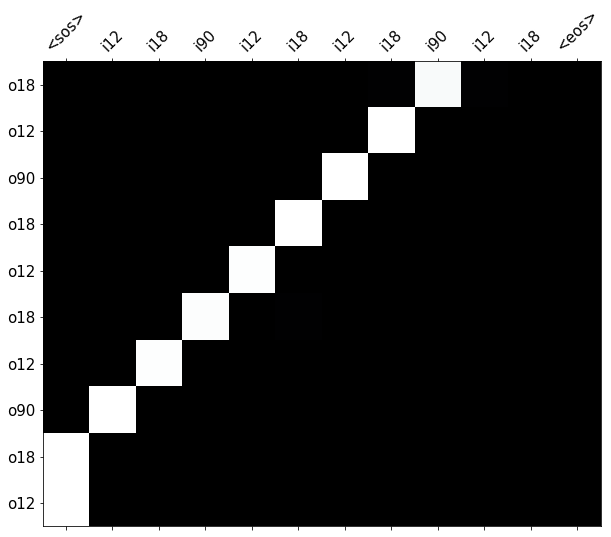

In [10]:
sentence = "i12 i18 i90 i12 i18 i12 i18 i90 i12 i18"
t, a = translate_sentence(model, sentence.split())
display_attention(sentence.split(), t, a)

In [ ]:
# print (a.shape)

## Notes

- Think about sample complexity 
- think about convergence time
- start with a pre-trained model
- try different seeds 


- plot all 10 attention maps for 10 different seeds
    - try averaged attention maps
- use a bilingual dictionary for en-de network...